<a href="https://colab.research.google.com/github/pratimakandel/CV_Recycling/blob/master/CVForRecyclingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all the libraries


import keras
import os
import time 
import cv2
import numpy as np
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization
from keras.applications import MobileNet
from keras.applications import InceptionV3
from keras.applications import VGG19
from keras.applications.mobilenet import preprocess_input
from keras.callbacks import ModelCheckpoint, CSVLogger
from IPython.display import Image

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array


In [2]:
print(tf.__version__)

2.4.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

!cp -r /content/drive/My\ Drive/data1/validation/ /content/


In [5]:
!cp -r /content/drive/My\ Drive/data1/train/ /content/

In [12]:
!cp -r /content/drive/My\ Drive/test/ /content/

In [6]:

from keras.applications import ResNet101V2

base_model = ResNet101V2(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

base_model.summary()

171319296/171317808 [==============================] - 2s 0us/step
Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
_____________________

In [7]:
#feature extraction 

base_model.trainable = False

for layer in base_model.layers:
	print("{}: {}".format(layer, layer.trainable))
 
 
 

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efc3a3da748>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc58f73208>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc3a4052e8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc38dfeeb8>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efc38d8fe10>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efc9202d4a8>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7efc38dbef28>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc356891d0>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efc356940b8>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7efc35694eb8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc3569bef0>: False
<tensorflow

In [8]:
 
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [9]:

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))


Number of trainable variables = 4


In [10]:

#optRMS = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
#optSGD = tf.keras.optimizers.SGD(learning_rate=0.0001)

# Let's create our model
model.compile(loss='categorical_crossentropy',
               optimizer=  tf.keras.optimizers.Adam(1e-5),
               metrics=['accuracy'])

In [13]:
img_width, img_height = 150, 150
train_data_dir = '/content/train'
validation_data_dir = '/content/validation'
nb_train_samples = 1278 #75750
nb_validation_samples = 115 #25250
batch_size = 35

train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    color_mode = 'rgb',
    seed = 32,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    color_mode = 'rgb',
    seed = 32,
    class_mode='categorical')

test_data_dir = '/content/test'
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=35,
    shuffle=False,
    color_mode = 'rgb',
    seed = 32,
    
    class_mode='categorical')

Found 2324 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 33 images belonging to 4 classes.


In [14]:
#data augmentation used in this experiment 
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.Rescaling(1./255),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2)
     
    ]
)

In [15]:
image_path="drive/My Drive/test1/glass4.jpg"
img = load_img(image_path, target_size=(150, 150))
image = np.expand_dims(img, axis=0)

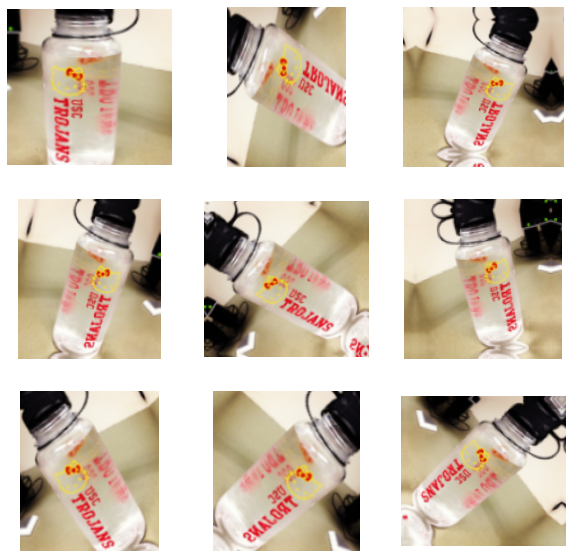

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [17]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((35, 150, 150, 3), (35, 4))

In [18]:

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  
  f.write(labels)

{'garbage': 0, 'glass': 1, 'metal': 2, 'plastic': 3}


In [19]:
!cat labels.txt

garbage
glass
metal
plastic

In [20]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator)) 


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
67/67 [==============================] - 383s 6s/step - loss: 1.8059 - accuracy: 0.4954 - val_loss: 0.8280 - val_accuracy: 0.7253
Epoch 2/20
67/67 [==============================] - 378s 6s/step - loss: 0.6541 - accuracy: 0.7831 - val_loss: 0.7144 - val_accuracy: 0.7619
Epoch 3/20
67/67 [==============================] - 374s 6s/step - loss: 0.5700 - accuracy: 0.8135 - val_loss: 0.7123 - val_accuracy: 0.7436
Epoch 4/20
67/67 [==============================] - 375s 6s/step - loss: 0.4043 - accuracy: 0.8555 - val_loss: 0.6595 - val_accuracy: 0.7839
Epoch 5/20
67/67 [==============================] - 378s 6s/step - loss: 0.3790 - accuracy: 0.8573 - val_loss: 0.6454 - val_accuracy: 0.7839
Epoch 6/20
67/67 [==============================] - 376s 6s/step - loss: 0.3041 - accuracy: 0.8905 - val_loss: 0.6090 - val_accuracy: 0.8168
Epoch 7/20
67/67 [==============================] - 378s 6s/step - loss: 0.3138 - accuracy: 0.8850 - val_loss: 0.6021 - val_accuracy: 0.7985
Epoch 8/20
67

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


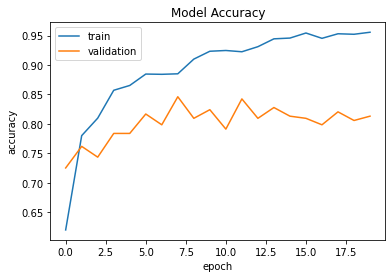

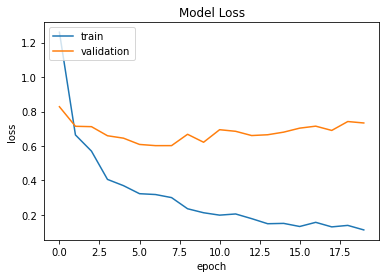

In [21]:
import matplotlib.pyplot as plt
import numpy
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate_generator(test_generator)
print("Accuracy = ", scores[1])

Accuracy =  0.7878788113594055


In [22]:
scores = model.evaluate_generator(test_generator)
print("Accuracy = ", scores[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy =  0.7272727489471436


In [23]:
#Fine tuning 
base_model.trainable = True



In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



Number of layers in the base model:  377


In [25]:

for layer in base_model.layers:
	print("{}: {}".format(layer, layer.trainable))
 

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7efc3a3da748>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc58f73208>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc3a4052e8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc38dfeeb8>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7efc38d8fe10>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efc9202d4a8>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7efc38dbef28>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7efc356891d0>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7efc356940b8>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7efc35694eb8>: False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7efc3569bef0>: False
<tensorflow

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])


In [27]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=20,
      validation_data=validation_generator,
      validation_steps=len(validation_generator))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
67/67 [==============================] - 1194s 18s/step - loss: 0.6329 - accuracy: 0.7663 - val_loss: 0.7228 - val_accuracy: 0.8168
Epoch 2/20
67/67 [==============================] - 1169s 17s/step - loss: 0.3786 - accuracy: 0.8581 - val_loss: 0.6914 - val_accuracy: 0.7766
Epoch 3/20
67/67 [==============================] - 1168s 17s/step - loss: 0.2987 - accuracy: 0.8814 - val_loss: 0.6788 - val_accuracy: 0.7985
Epoch 4/20
67/67 [==============================] - 1170s 17s/step - loss: 0.2158 - accuracy: 0.9235 - val_loss: 0.7120 - val_accuracy: 0.8132
Epoch 5/20
67/67 [==============================] - 1167s 17s/step - loss: 0.2031 - accuracy: 0.9206 - val_loss: 0.7532 - val_accuracy: 0.8022
Epoch 6/20
67/67 [==============================] - 1167s 17s/step - loss: 0.1879 - accuracy: 0.9283 - val_loss: 0.7130 - val_accuracy: 0.7949
Epoch 7/20
67/67 [==============================] - 1166s 17s/step - loss: 0.1508 - accuracy: 0.9403 - val_loss: 0.6912 - val_accuracy: 0.8095

In [29]:
scores1 = model.evaluate_generator(test_generator)
print("Accuracy = ", scores1[1])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Accuracy =  0.8181818127632141


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


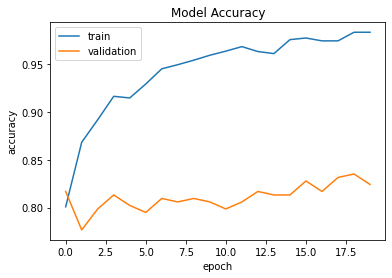

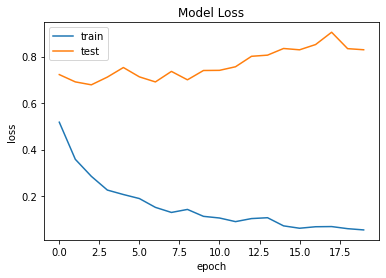

In [30]:
import matplotlib.pyplot as plt
import numpy
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[0.03432157 0.42017627 0.08426985 0.46123233]]
3
plastic


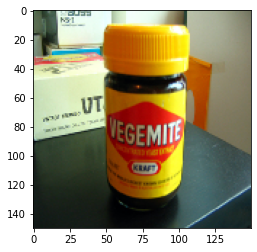

In [39]:
 #To test the model with a single image 
#Use the function below to test muliple images at once 
from google.colab.patches import cv2_imshow
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

#To load existing model
#model = load_model('drive/My Drive/test1/testing.h5')
image_path="drive/My Drive/test1/plastic3.jpg"
img = load_img(image_path, target_size=(150, 150))
plt.imshow(img)
x = img_to_array(img)
# Rescale image
x = x / 255.
image = np.expand_dims(x, axis=0)
pred = model.predict(image)
index = np.argmax(pred)
np.set_printoptions(suppress=True)
print(pred)
print(index)
if index == 0:
  label = "Unknown"
elif index == 1:
  label = "glass"
elif index == 2:
  label = "metal"
elif index == 3:
  label = "plastic" 
print(label)


In [32]:
data = []

In [33]:

for filename in os.listdir("drive/My Drive/testtt/"):
    if filename.endswith("jpg"): 
        img = load_img("drive/My Drive/testtt/" + filename, target_size=(150, 150))
        data.append(img)

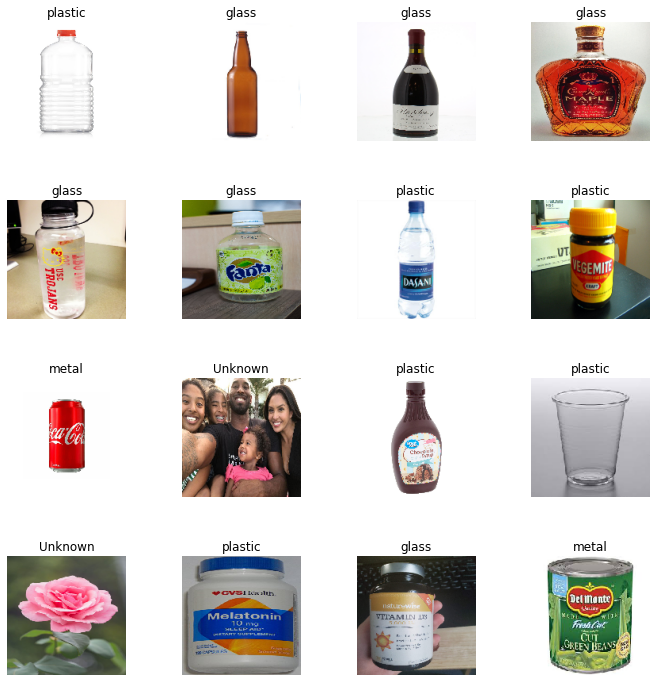

In [34]:
from google.colab.patches import cv2_imshow
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
count = 0
label = ""
for img in data:
  count = count + 1
  plt.subplot(4,4,count)
  #loaded_model = load_model(model)
  x = img_to_array(img)   
  x = x / 255.             
  img2 = np.expand_dims(x, axis=0)
  pred = model.predict(img2)
  index = np.argmax(pred)
  plt.imshow(img, cmap=plt.cm.binary)
  plt.axis('off')
  if index == 0:
    label = "Unknown"
  elif index == 1:
    label = "glass"
  elif index == 2:
    label = "metal"
  elif index == 3:
    label = "plastic" 
  plt.title(label)

In [35]:
#Convert model to Tensorflow lite

saved_model_dir = 'drive/My Drive/save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('ResNet101V2.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: drive/My Drive/save/fine_tuning/assets


In [36]:
from google.colab import files                                                      

files.download('ResNet101V2.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import numpy as np
import tensorflow as tf

# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path="/content/ResNet101V2.tflite")

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_resnet101v2_input:0
shape: [  1 150 150   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 4]
type: <class 'numpy.float32'>
